<a href="https://colab.research.google.com/github/jamessen17/ITAD-Portfolio-Project/blob/main/ITAD_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Faker
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from faker import Faker
import os

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
fake = Faker()
Faker.seed(42)

class ITADDataGenerator:
    def __init__(self, num_assets=5000):
        self.num_assets = num_assets
        self.start_date = datetime(2020, 1, 1)
        self.end_date = datetime(2024, 12, 31)

        # Industry-realistic parameters
        self.device_types = {
            'Laptop': {'weight': 40, 'avg_price': 800, 'lifespan': 4, 'refurb_success': 0.82},
            'Desktop': {'weight': 25, 'avg_price': 600, 'lifespan': 5, 'refurb_success': 0.78},
            'Server': {'weight': 15, 'avg_price': 3000, 'lifespan': 6, 'refurb_success': 0.65},
            'Monitor': {'weight': 10, 'avg_price': 300, 'lifespan': 7, 'refurb_success': 0.85},
            'Tablet': {'weight': 8, 'avg_price': 400, 'lifespan': 3, 'refurb_success': 0.75},
            'Smartphone': {'weight': 2, 'avg_price': 500, 'lifespan': 2.5, 'refurb_success': 0.70}
        }

        self.brands = {
            'Dell': 0.25, 'HP': 0.22, 'Lenovo': 0.18, 'Apple': 0.12,
            'Acer': 0.08, 'ASUS': 0.06, 'Samsung': 0.05, 'Other': 0.04
        }

        self.customer_types = {
            'Enterprise': 0.45, 'SMB': 0.25, 'Education': 0.15,
            'Government': 0.10, 'Consumer': 0.05
        }

        self.sale_channels = {
            'Direct_B2B': 0.35, 'Online_Marketplace': 0.25, 'Retail_Partner': 0.20,
            'Auction': 0.12, 'Export': 0.08
        }

        # Carbon footprint data (kg CO2e)
        self.carbon_footprints = {
            'Laptop': 300, 'Desktop': 250, 'Server': 1200,
            'Monitor': 200, 'Tablet': 150, 'Smartphone': 80
        }

    def generate_weighted_choice(self, choices_dict):
        """Generate weighted random choices"""
        choices = list(choices_dict.keys())
        # Check if the values are dictionaries and extract 'weight' if they are, otherwise use the value directly
        weights = [v.get('weight') if isinstance(v, dict) else v for v in choices_dict.values()]
        # Normalize weights
        total_weight = sum(weights)
        normalized_weights = [w / total_weight for w in weights]
        return np.random.choice(choices, p=normalized_weights)


    def generate_assets_table(self):
        """Generate the main assets table"""
        print("Generating assets table...")

        assets = []
        for i in range(self.num_assets):
            device_type = self.generate_weighted_choice(self.device_types)
            brand = self.generate_weighted_choice(self.brands)

            # Generate acquisition date with seasonal patterns
            # More corporate disposals in Q4, education in summer
            month_weights = [0.06, 0.06, 0.08, 0.08, 0.09, 0.12, 0.11, 0.12, 0.08, 0.08, 0.06, 0.06]
            month = np.random.choice(range(1, 13), p=month_weights)
            year = np.random.choice(range(2020, 2025), p=[0.15, 0.20, 0.25, 0.25, 0.15])
            day = np.random.randint(1, 29)
            acquisition_date = datetime(year, month, day)

            # Calculate age and condition
            age_months = (self.end_date - acquisition_date).days / 30.44
            expected_lifespan = self.device_types[device_type]['lifespan'] * 12
            age_factor = min(age_months / expected_lifespan, 2.0)

            # Condition score (1-10) based on age and device type
            base_condition = 10 - (age_factor * 4)
            condition_score = max(1, min(10, base_condition + np.random.normal(0, 1)))

            # Original price with inflation and brand premium
            base_price = self.device_types[device_type]['avg_price']
            brand_multiplier = 1.3 if brand == 'Apple' else 1.1 if brand in ['Dell', 'HP'] else 1.0
            inflation_factor = 1 + (year - 2020) * 0.03
            original_price = base_price * brand_multiplier * inflation_factor * np.random.uniform(0.8, 1.2)

            # Refurbishment potential based on condition and age
            refurb_potential = 'High' if condition_score > 7 and age_months < expected_lifespan else \
                              'Medium' if condition_score > 4 and age_months < expected_lifespan * 1.5 else 'Low'

            # Carbon footprint
            carbon_footprint = self.carbon_footprints[device_type] * np.random.uniform(0.9, 1.1)

            # Generate realistic model names
            model_suffix = f"{random.choice(['Pro', 'Elite', 'ThinkPad', 'Inspiron', 'Latitude', 'Pavilion', ''])}{random.randint(1000, 9999)}"
            model = f"{brand} {model_suffix}".strip()

            assets.append({
                'asset_id': f'AST{str(i+1).zfill(6)}',
                'device_type': device_type,
                'brand': brand,
                'model': model,
                'acquisition_date': acquisition_date.strftime('%Y-%m-%d'),
                'condition_score': round(condition_score, 1),
                'original_price': round(original_price, 2),
                'age_months': round(age_months, 1),
                'refurb_potential': refurb_potential,
                'carbon_footprint_kg': round(carbon_footprint, 1)
            })

        return pd.DataFrame(assets)

    def generate_refurbishment_process(self, assets_df):
        """Generate refurbishment process data"""
        print("Generating refurbishment process table...")

        # Only process assets that were acquired and have some refurb potential
        processable_assets = assets_df[
            (pd.to_datetime(assets_df['acquisition_date']) < datetime(2024, 10, 1)) &
            (assets_df['refurb_potential'].isin(['High', 'Medium']))
        ].copy()

        refurb_data = []

        for _, asset in processable_assets.iterrows():
            # Skip some assets (not all get processed)
            if np.random.random() > 0.85:  # 85% of viable assets get processed
                continue

            acquisition_date = pd.to_datetime(asset['acquisition_date'])

            # Intake date (1-30 days after acquisition)
            intake_delay = np.random.exponential(7)  # Average 7 days
            intake_date = acquisition_date + timedelta(days=min(intake_delay, 30))

            # Assessment duration (2-8 hours)
            assessment_duration = np.random.gamma(2, 1.5) + 1  # Gamma distribution
            assessment_duration = min(assessment_duration, 8)

            # Refurbishment start (1-14 days after intake)
            refurb_delay = np.random.exponential(3) + 1
            refurb_start = intake_date + timedelta(days=min(refurb_delay, 14))

            # Refurbishment duration based on device type and condition
            device_type = asset['device_type']
            condition_score = asset['condition_score']

            base_duration = {
                'Laptop': 4, 'Desktop': 3, 'Server': 12,
                'Monitor': 2, 'Tablet': 3, 'Smartphone': 2
            }[device_type]

            # Lower condition = longer refurb time
            duration_multiplier = 2.5 - (condition_score / 5)
            refurb_duration = base_duration * duration_multiplier * np.random.uniform(0.7, 1.3)
            refurb_completion = refurb_start + timedelta(hours=refurb_duration)

            # Parts cost based on condition and device type
            base_parts_cost = {
                'Laptop': 50, 'Desktop': 40, 'Server': 200,
                'Monitor': 30, 'Tablet': 35, 'Smartphone': 25
            }[device_type]

            condition_multiplier = 1.5 - (condition_score / 10)
            parts_cost = base_parts_cost * condition_multiplier * np.random.uniform(0.5, 2.0)

            # Labor hours
            labor_hours = refurb_duration + np.random.normal(0, 1)
            labor_hours = max(1, labor_hours)

            # Final condition score (usually improves)
            improvement = np.random.uniform(0.5, 2.0)
            final_condition_score = min(10, condition_score + improvement)

            # Refurbishment success based on original condition and device type
            success_probability = self.device_types[device_type]['refurb_success']
            if condition_score < 4:
                success_probability *= 0.7
            elif condition_score > 7:
                success_probability *= 1.1

            refurb_success = np.random.random() < success_probability

            # Certification achieved (for successful refurbs)
            certification = None
            if refurb_success:
                cert_options = ['R2', 'e-Stewards', 'ISO14001', 'None']
                cert_weights = [0.4, 0.3, 0.2, 0.1]
                certification = np.random.choice(cert_options, p=cert_weights)

            refurb_data.append({
                'asset_id': asset['asset_id'],
                'intake_date': intake_date.strftime('%Y-%m-%d'),
                'assessment_duration_hrs': round(assessment_duration, 1),
                'refurb_start_date': refurb_start.strftime('%Y-%m-%d'),
                'refurb_completion_date': refurb_completion.strftime('%Y-%m-%d'),
                'parts_cost': round(parts_cost, 2),
                'labor_hours': round(labor_hours, 1),
                'final_condition_score': round(final_condition_score, 1),
                'refurb_success': refurb_success,
                'certification_achieved': certification
            })

        return pd.DataFrame(refurb_data)

    def generate_sales_data(self, assets_df, refurb_df):
        """Generate sales data for successfully refurbished assets"""
        print("Generating sales data...")

        # Get successfully refurbished assets
        successful_refurb = refurb_df[refurb_df['refurb_success'] == True].copy()

        sales_data = []

        for _, refurb in successful_refurb.iterrows():
            # Skip some assets (not all sell immediately)
            if np.random.random() > 0.90:  # 90% of refurb assets sell
                continue

            asset_info = assets_df[assets_df['asset_id'] == refurb['asset_id']].iloc[0]

            # Sale date (1-90 days after refurbishment completion)
            refurb_completion = pd.to_datetime(refurb['refurb_completion_date'])
            sale_delay = np.random.exponential(20) + 1  # Average 20 days
            sale_date = refurb_completion + timedelta(days=min(sale_delay, 90))

            # Sale price based on final condition, device type, and market factors
            device_type = asset_info['device_type']
            final_condition = refurb['final_condition_score']
            original_price = asset_info['original_price']

            # Base depreciation
            age_months = asset_info['age_months']
            depreciation_rate = 0.15  # 15% per year
            age_factor = (1 - depreciation_rate) ** (age_months / 12)

            # Condition premium
            condition_factor = 0.4 + (final_condition / 10) * 0.5  # 40-90% of original

            # Market demand factor (seasonal)
            month = sale_date.month
            seasonal_factor = 1.1 if month in [11, 12, 1] else 0.95 if month in [6, 7, 8] else 1.0

            sale_price = original_price * age_factor * condition_factor * seasonal_factor
            sale_price *= np.random.uniform(0.8, 1.2)  # Market variation

            # Sale channel
            sale_channel = self.generate_weighted_choice(self.sale_channels)

            # Customer type
            customer_type = self.generate_weighted_choice(self.customer_types)

            # Warranty months based on condition and channel
            warranty_base = {'High': 12, 'Medium': 6, 'Low': 3}
            warranty_months = warranty_base.get(asset_info['refurb_potential'], 6)
            if sale_channel in ['Online_Marketplace', 'Auction']:
                warranty_months = max(1, warranty_months // 2)

            # Shipping cost
            shipping_base = {'Laptop': 15, 'Desktop': 25, 'Server': 50,
                           'Monitor': 20, 'Tablet': 10, 'Smartphone': 8}
            shipping_cost = shipping_base[device_type] * np.random.uniform(0.8, 1.2)

            # Customer satisfaction (higher for better condition/service)
            satisfaction_base = 4.2  # Base satisfaction
            condition_bonus = (final_condition - 5) * 0.15
            warranty_bonus = warranty_months * 0.02
            satisfaction = min(5.0, satisfaction_base + condition_bonus + warranty_bonus + np.random.normal(0, 0.3))

            sales_data.append({
                'asset_id': refurb['asset_id'],
                'sale_date': sale_date.strftime('%Y-%m-%d'),
                'sale_price': round(sale_price, 2),
                'sale_channel': sale_channel,
                'customer_type': customer_type,
                'warranty_months': warranty_months,
                'shipping_cost': round(shipping_cost, 2),
                'customer_satisfaction': round(satisfaction, 1)
            })

        return pd.DataFrame(sales_data)

    def generate_environmental_impact(self, assets_df, refurb_df, sales_df):
        """Generate environmental impact data"""
        print("Generating environmental impact data...")

        environmental_data = []

        # Get all assets with refurbishment attempts
        for _, refurb in refurb_df.iterrows():
            asset_info = assets_df[assets_df['asset_id'] == refurb['asset_id']].iloc[0]

            original_carbon = asset_info['carbon_footprint_kg']

            # Refurbishment carbon cost (5-15% of original manufacturing)
            refurb_carbon_cost = original_carbon * np.random.uniform(0.05, 0.15)

            if refurb['refurb_success']:
                # Successful refurbishment avoids new manufacturing
                avoided_emissions = original_carbon * np.random.uniform(0.75, 0.85)  # 75-85% savings

                # Materials recovered (based on device type)
                device_type = asset_info['device_type']
                material_recovery_rates = {
                    'Laptop': {'metals': 0.65, 'plastics': 0.45, 'rare_earth': 0.30},
                    'Desktop': {'metals': 0.70, 'plastics': 0.50, 'rare_earth': 0.25},
                    'Server': {'metals': 0.75, 'plastics': 0.40, 'rare_earth': 0.40},
                    'Monitor': {'metals': 0.60, 'plastics': 0.55, 'rare_earth': 0.20},
                    'Tablet': {'metals': 0.50, 'plastics': 0.35, 'rare_earth': 0.35},
                    'Smartphone': {'metals': 0.45, 'plastics': 0.30, 'rare_earth': 0.40}
                }

                device_weights = {
                    'Laptop': 2.5, 'Desktop': 8.0, 'Server': 15.0,
                    'Monitor': 5.0, 'Tablet': 0.5, 'Smartphone': 0.2
                }

                device_weight = device_weights[device_type]
                recovery_rates = material_recovery_rates[device_type]

                metals_recovered = device_weight * recovery_rates['metals'] * np.random.uniform(0.8, 1.2)
                plastics_recovered = device_weight * recovery_rates['plastics'] * np.random.uniform(0.8, 1.2)
                rare_earth_recovered = device_weight * recovery_rates['rare_earth'] * np.random.uniform(0.8, 1.2)

                total_materials_recovered = metals_recovered + plastics_recovered + rare_earth_recovered

                # Landfill diversion
                landfill_diversion = device_weight * 0.90  # 90% diverted from landfill

                # Circular economy value (monetary value of extending product life)
                sale_info = sales_df[sales_df['asset_id'] == refurb['asset_id']]
                if not sale_info.empty:
                    sale_price = sale_info.iloc[0]['sale_price']
                    circular_economy_value = sale_price * 0.7  # 70% attributed to circular value
                else:
                    circular_economy_value = original_carbon * 0.3  # Fallback value
            else:
                # Failed refurbishment - recycling only
                avoided_emissions = original_carbon * np.random.uniform(0.15, 0.25)  # 15-25% savings
                total_materials_recovered = device_weights[asset_info['device_type']] * 0.60
                landfill_diversion = device_weights[asset_info['device_type']] * 0.85
                circular_economy_value = 0

            environmental_data.append({
                'asset_id': refurb['asset_id'],
                'original_carbon_footprint': round(original_carbon, 1),
                'refurb_carbon_cost': round(refurb_carbon_cost, 1),
                'avoided_new_manufacturing_emissions': round(avoided_emissions, 1),
                'materials_recovered_kg': round(total_materials_recovered, 2),
                'landfill_diversion_kg': round(landfill_diversion, 2),
                'circular_economy_value': round(circular_economy_value, 2)
            })

        return pd.DataFrame(environmental_data)

    def generate_all_datasets(self, output_dir='itad_datasets'):
        """Generate all datasets and save to CSV files"""
        print("Starting ITAD dataset generation...")

        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Generate datasets
        assets_df = self.generate_assets_table()
        refurb_df = self.generate_refurbishment_process(assets_df)
        sales_df = self.generate_sales_data(assets_df, refurb_df)
        environmental_df = self.generate_environmental_impact(assets_df, refurb_df, sales_df)

        # Save to CSV
        assets_df.to_csv(f'{output_dir}/assets.csv', index=False)
        refurb_df.to_csv(f'{output_dir}/refurbishment_process.csv', index=False)
        sales_df.to_csv(f'{output_dir}/sales.csv', index=False)
        environmental_df.to_csv(f'{output_dir}/environmental_impact.csv', index=False)

        # Generate summary statistics
        summary = {
            'Total Assets': len(assets_df),
            'Assets Processed': len(refurb_df),
            'Successful Refurbishments': len(refurb_df[refurb_df['refurb_success']]),
            'Assets Sold': len(sales_df),
            'Total Revenue': sales_df['sale_price'].sum(),
            'Total Carbon Saved (kg)': environmental_df['avoided_new_manufacturing_emissions'].sum(),
            'Processing Success Rate': f"{(refurb_df['refurb_success'].sum() / len(refurb_df) * 100):.1f}%"
        }

        print(f"\nDataset Generation Complete!")
        print(f"Files saved to '{output_dir}/' directory:")
        print(f"- assets.csv ({len(assets_df)} records)")
        print(f"- refurbishment_process.csv ({len(refurb_df)} records)")
        print(f"- sales.csv ({len(sales_df)} records)")
        print(f"- environmental_impact.csv ({len(environmental_df)} records)")

        print(f"\nDataset Summary:")
        for key, value in summary.items():
            print(f"- {key}: {value}")

        return assets_df, refurb_df, sales_df, environmental_df

# Example usage
if __name__ == "__main__":
    # Generate datasets with 5000 assets
    generator = ITADDataGenerator(num_assets=5000)
    assets, refurb, sales, environmental = generator.generate_all_datasets()

    # Preview the first few rows of each dataset
    print("\n" + "="*50)
    print("PREVIEW OF GENERATED DATASETS")
    print("="*50)

    print("\nAssets Sample:")
    print(assets.head(3).to_string())

    print("\nRefurbishment Process Sample:")
    print(refurb.head(3).to_string())

    print("\nSales Sample:")
    print(sales.head(3).to_string())

    print("\nEnvironmental Impact Sample:")
    print(environmental.head(3).to_string())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.1 MB/s eta 0:00:00
Starting ITAD dataset generation...
Generating assets table...
Generating refurbishment process table...
Generating sales data...
Generating environmental impact data...

Dataset Generation Complete!
Files saved to 'itad_datasets/' directory:
- assets.csv (5000 records)
- refurbishment_process.csv (4019 records)
- sales.csv (3050 records)
- environmental_impact.csv (4019 records)

Dataset Summary:
- Total Assets: 5000
- Assets Processed: 4019
- Successful Refurbishments: 3344
- Assets Sold: 3050
- Total Revenue: 1927285.44
- Total Carbon Saved (kg): 1080361.8
- Processing Success Rate: 83.2%

PREVIEW OF GENERATED DATASETS

Assets Sample:
    asset_id device_type    brand                 model acquisition_date  condition_score  original_price  age_months refurb_potential  carbon_footprint_kg
0  AST000001      Laptop  Samsung  Samsung Pavilion2824       2022-09-07              6.8          834.18        27.8    

# Task
Explain the error in the selected code, fix it if possible, and incorporate the changes into the existing code. Otherwise, diagnose the error.

## Prepare data for visualization

### Subtask:
Ensure the necessary columns are in the correct format (e.g., dates as datetime objects, numerical columns as numbers).


**Reasoning**:
Convert date columns to datetime objects and ensure numerical columns have appropriate data types for better analysis.



In [ ]:
# Convert date columns to datetime objects
assets['acquisition_date'] = pd.to_datetime(assets['acquisition_date'])
refurb['intake_date'] = pd.to_datetime(refurb['intake_date'])
refurb['refurb_start_date'] = pd.to_datetime(refurb['refurb_start_date'])
refurb['refurb_completion_date'] = pd.to_datetime(refurb['refurb_completion_date'])
sales['sale_date'] = pd.to_datetime(sales['sale_date'])

# Ensure numerical columns are of appropriate data types (float or int)
# Monetary values
assets['original_price'] = assets['original_price'].astype(float)
refurb['parts_cost'] = refurb['parts_cost'].astype(float)
sales['sale_price'] = sales['sale_price'].astype(float)
sales['shipping_cost'] = sales['shipping_cost'].astype(float)
environmental['circular_economy_value'] = environmental['circular_economy_value'].astype(float)

# Weights/Quantities
assets['carbon_footprint_kg'] = assets['carbon_footprint_kg'].astype(float)
environmental['materials_recovered_kg'] = environmental['materials_recovered_kg'].astype(float)
environmental['landfill_diversion_kg'] = environmental['landfill_diversion_kg'].astype(float)

# Other numerical columns
assets['condition_score'] = assets['condition_score'].astype(float)
assets['age_months'] = assets['age_months'].astype(float)
refurb['assessment_duration_hrs'] = refurb['assessment_duration_hrs'].astype(float)
refurb['labor_hours'] = refurb['labor_hours'].astype(float)
refurb['final_condition_score'] = refurb['final_condition_score'].astype(float)
sales['warranty_months'] = sales['warranty_months'].astype(int) # Warranty is in months, should be integer
sales['customer_satisfaction'] = sales['customer_satisfaction'].astype(float)
environmental['original_carbon_footprint'] = environmental['original_carbon_footprint'].astype(float)
environmental['refurb_carbon_cost'] = environmental['refurb_carbon_cost'].astype(float)
environmental['avoided_new_manufacturing_emissions'] = environmental['avoided_new_manufacturing_emissions'].astype(float)

# Display info to verify data types
print("Data types after cleaning:")
assets.info()
refurb.info()
sales.info()
environmental.info()

Data types after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   asset_id             5000 non-null   object        
 1   device_type          5000 non-null   object        
 2   brand                5000 non-null   object        
 3   model                5000 non-null   object        
 4   acquisition_date     5000 non-null   datetime64[ns]
 5   condition_score      5000 non-null   float64       
 6   original_price       5000 non-null   float64       
 7   age_months           5000 non-null   float64       
 8   refurb_potential     5000 non-null   object        
 9   carbon_footprint_kg  5000 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 390.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 10 columns):
 #

## Visualize sales data

### Subtask:
Create visualizations to explore trends in sales data, such as sales revenue over time or sales by device type or channel.


**Reasoning**:
Import the necessary libraries for plotting and create the first plot showing total sales revenue over time.



/tmp/ipython-input-2860171191.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_over_time = sales.set_index('sale_date').resample('M')['sale_price'].sum()


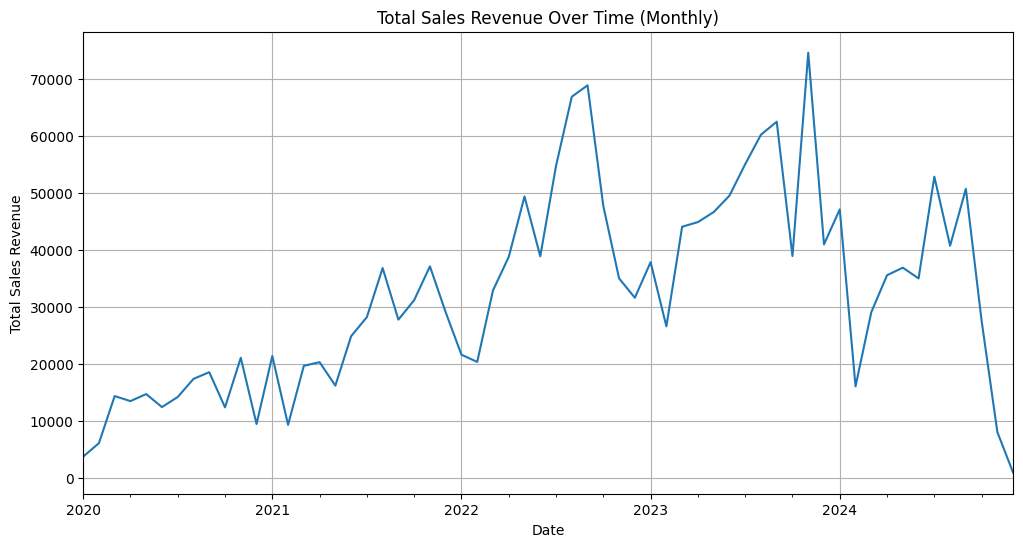

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot total sales revenue over time
sales_over_time = sales.set_index('sale_date').resample('M')['sale_price'].sum()

plt.figure(figsize=(12, 6))
sales_over_time.plot(kind='line')
plt.title('Total Sales Revenue Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Total Sales Revenue')
plt.grid(True)
plt.show()

**Reasoning**:
Create a bar plot showing total sales revenue by device type by merging the sales and assets dataframes and then grouping by device type.



/tmp/ipython-input-3371082984.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_by_device_type.index, y=sales_by_device_type.values, palette='viridis')


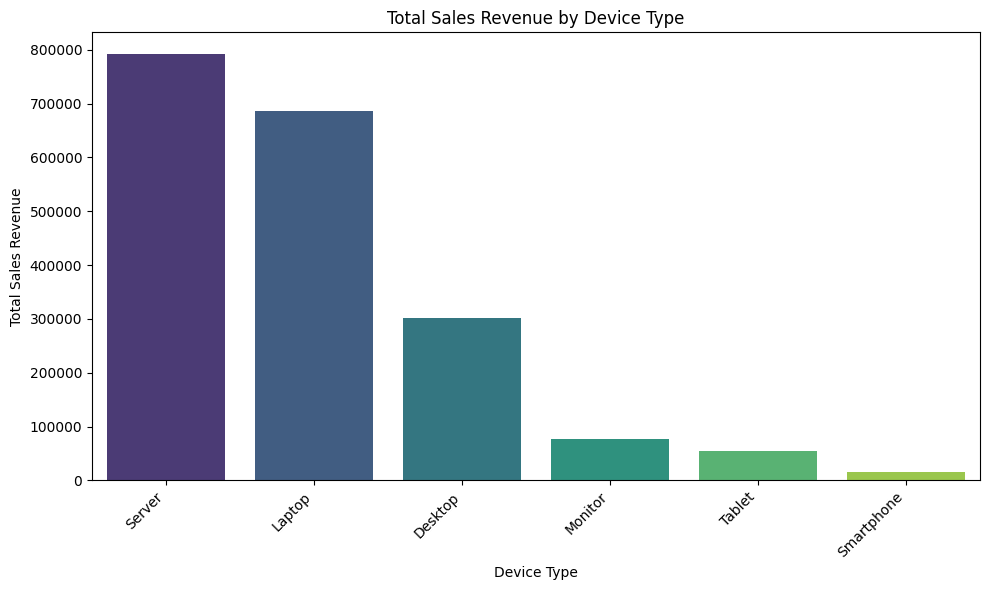

In [ ]:
# Merge sales and assets dataframes to get device type
sales_with_device = pd.merge(sales, assets[['asset_id', 'device_type']], on='asset_id', how='left')

# Calculate total sales revenue by device type
sales_by_device_type = sales_with_device.groupby('device_type')['sale_price'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_device_type.index, y=sales_by_device_type.values, palette='viridis')
plt.title('Total Sales Revenue by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Total Sales Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
Create a bar plot showing total sales revenue by sale channel using the sales dataframe.



/tmp/ipython-input-177471622.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_by_channel.index, y=sales_by_channel.values, palette='viridis')


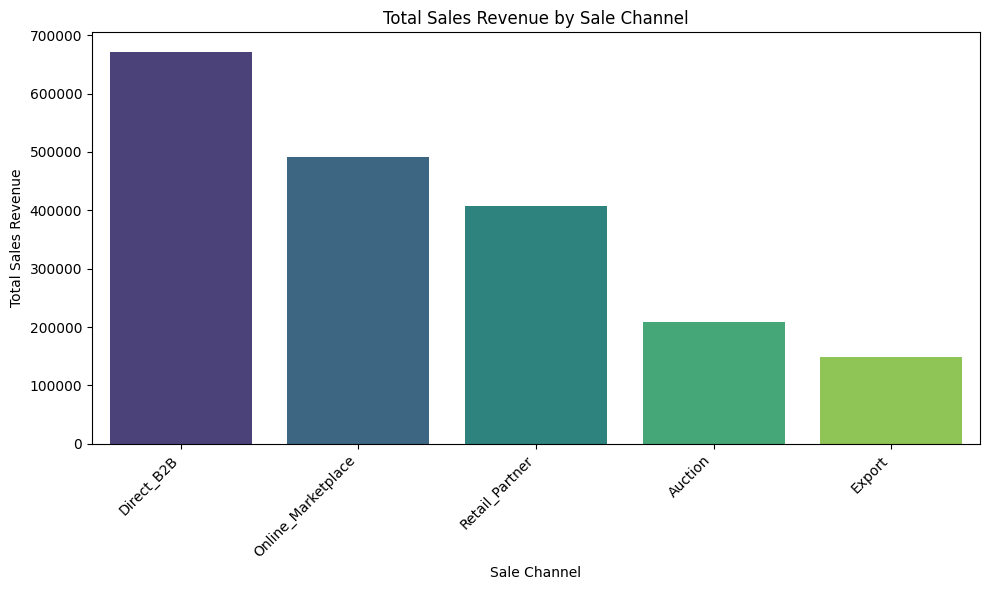

In [ ]:
# Calculate total sales revenue by sale channel
sales_by_channel = sales.groupby('sale_channel')['sale_price'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=sales_by_channel.index, y=sales_by_channel.values, palette='viridis')
plt.title('Total Sales Revenue by Sale Channel')
plt.xlabel('Sale Channel')
plt.ylabel('Total Sales Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualize refurbishment data

### Subtask:
Create visualizations to understand the refurbishment process, such as the success rate of refurbishment by device type or the distribution of refurbishment duration.


**Reasoning**:
Calculate the refurbishment success rate by device type, plot the success rate, plot the distribution of refurbishment duration, and plot the distribution of assessment duration by device type.



/tmp/ipython-input-1403245557.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=refurb_success_rate.index, y=refurb_success_rate.values, palette='viridis')


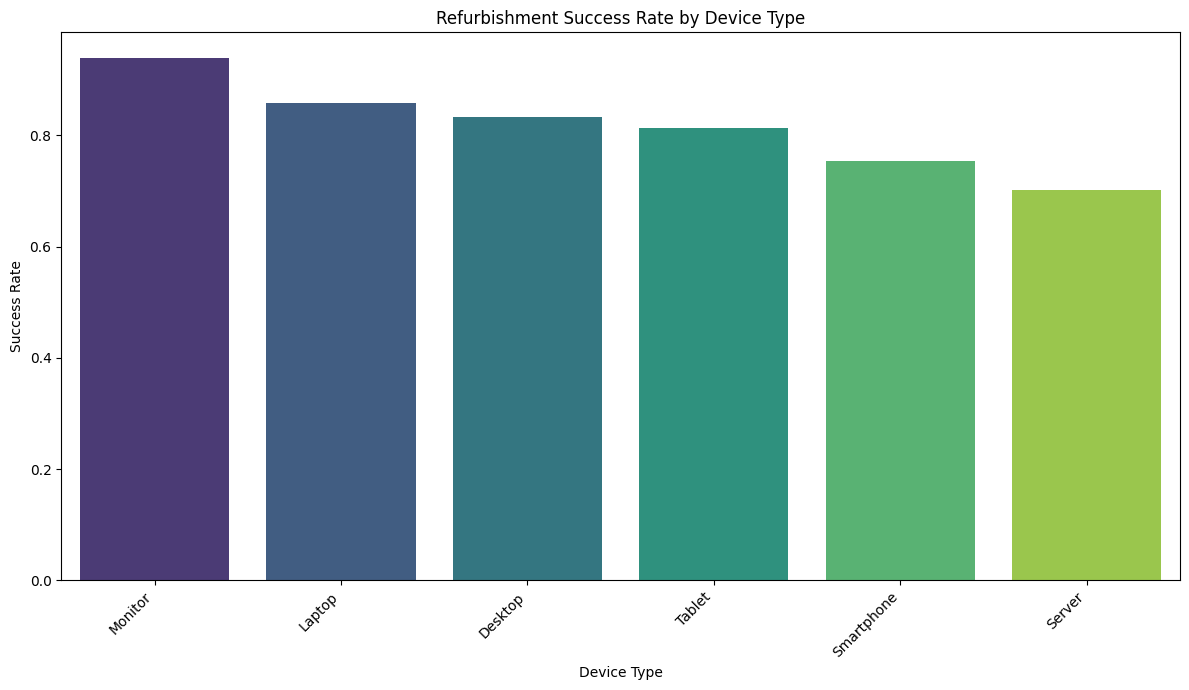

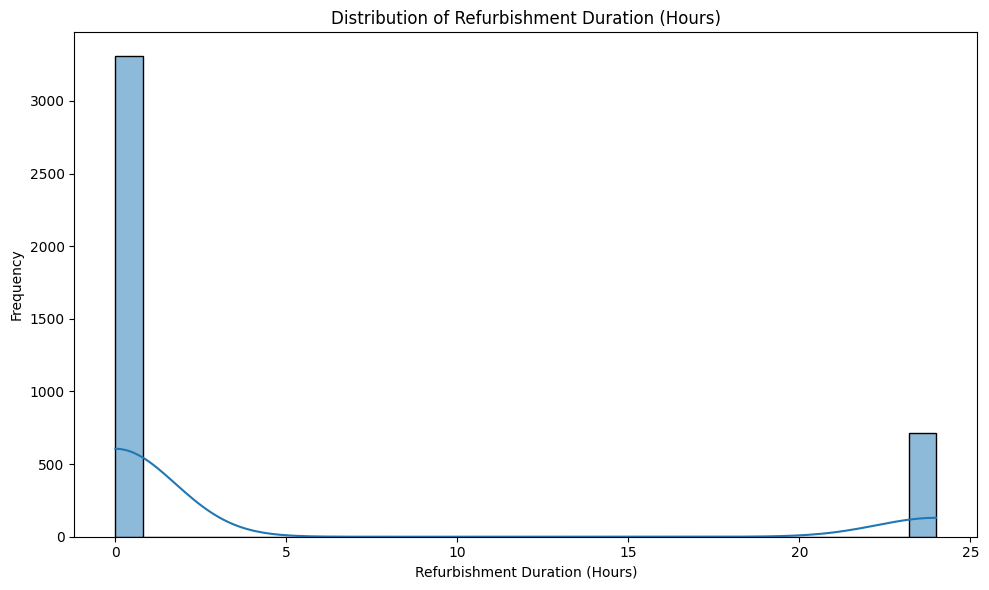

/tmp/ipython-input-1403245557.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='device_type', y='assessment_duration_hrs', data=refurb_with_assets, palette='viridis')


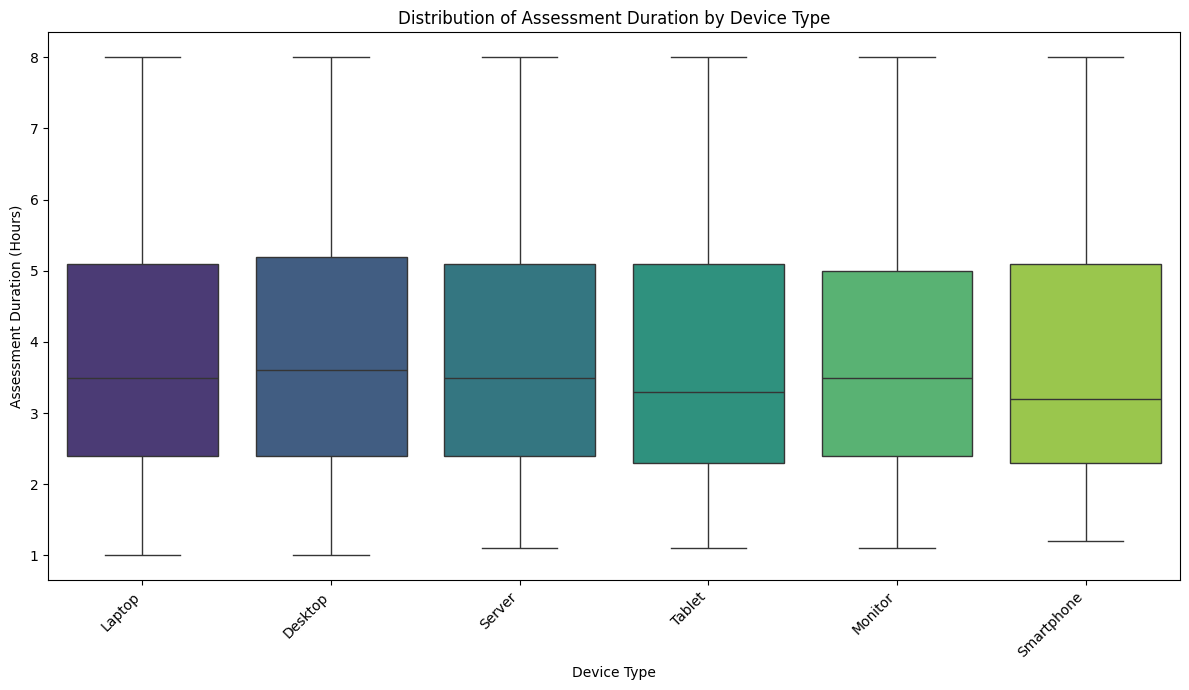

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the refurbishment success rate by device type
refurb_with_assets = pd.merge(refurb, assets[['asset_id', 'device_type']], on='asset_id', how='left')
refurb_success_rate = refurb_with_assets.groupby('device_type')['refurb_success'].mean().sort_values(ascending=False)

# 2. Create a bar plot for refurbishment success rate by device type
plt.figure(figsize=(12, 7))
sns.barplot(x=refurb_success_rate.index, y=refurb_success_rate.values, palette='viridis')
plt.title('Refurbishment Success Rate by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate refurb_duration before plotting
refurb['refurb_duration'] = (refurb['refurb_completion_date'] - refurb['refurb_start_date']).dt.total_seconds() / 3600

# 3. Plot a histogram for refurbishment duration
plt.figure(figsize=(10, 6))
sns.histplot(refurb['refurb_duration'], bins=30, kde=True)
plt.title('Distribution of Refurbishment Duration (Hours)')
plt.xlabel('Refurbishment Duration (Hours)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 4. Create a box plot for assessment duration by device type
plt.figure(figsize=(12, 7))
sns.boxplot(x='device_type', y='assessment_duration_hrs', data=refurb_with_assets, palette='viridis')
plt.title('Distribution of Assessment Duration by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Assessment Duration (Hours)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualize environmental impact

### Subtask:
Create visualizations to show the environmental benefits, such as total carbon saved over time or carbon savings by device type.


**Reasoning**:
The first few steps involve preparing the environmental data by converting a date column and then grouping and aggregating the data by month to calculate the total carbon saved over time. This can be done in a single code block.



In [ ]:
# Convert the 'refurb_completion_date' column to datetime objects (already done in previous step, but re-confirming for clarity)
# environmental['refurb_completion_date'] = pd.to_datetime(environmental['refurb_completion_date'])

# Group by month and calculate the sum of 'avoided_new_manufacturing_emissions'
carbon_saved_over_time = environmental.set_index('refurb_completion_date').resample('ME')['avoided_new_manufacturing_emissions'].sum()

# Create a line plot
plt.figure(figsize=(14, 7))
carbon_saved_over_time.plot(kind='line')
plt.title('Total Carbon Saved Over Time (by Refurbishment Completion Month)')
plt.xlabel('Month')
plt.ylabel('Total Carbon Saved (kg CO2e)')
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: "None of ['refurb_completion_date'] are in the columns"

**Reasoning**:
The previous code failed because the `environmental` dataframe does not contain the 'refurb_completion_date' column. This date information is in the `refurb` dataframe. To calculate carbon savings over time based on refurbishment completion, I need to merge the `environmental` and `refurb` dataframes first, then proceed with the grouping and plotting steps.



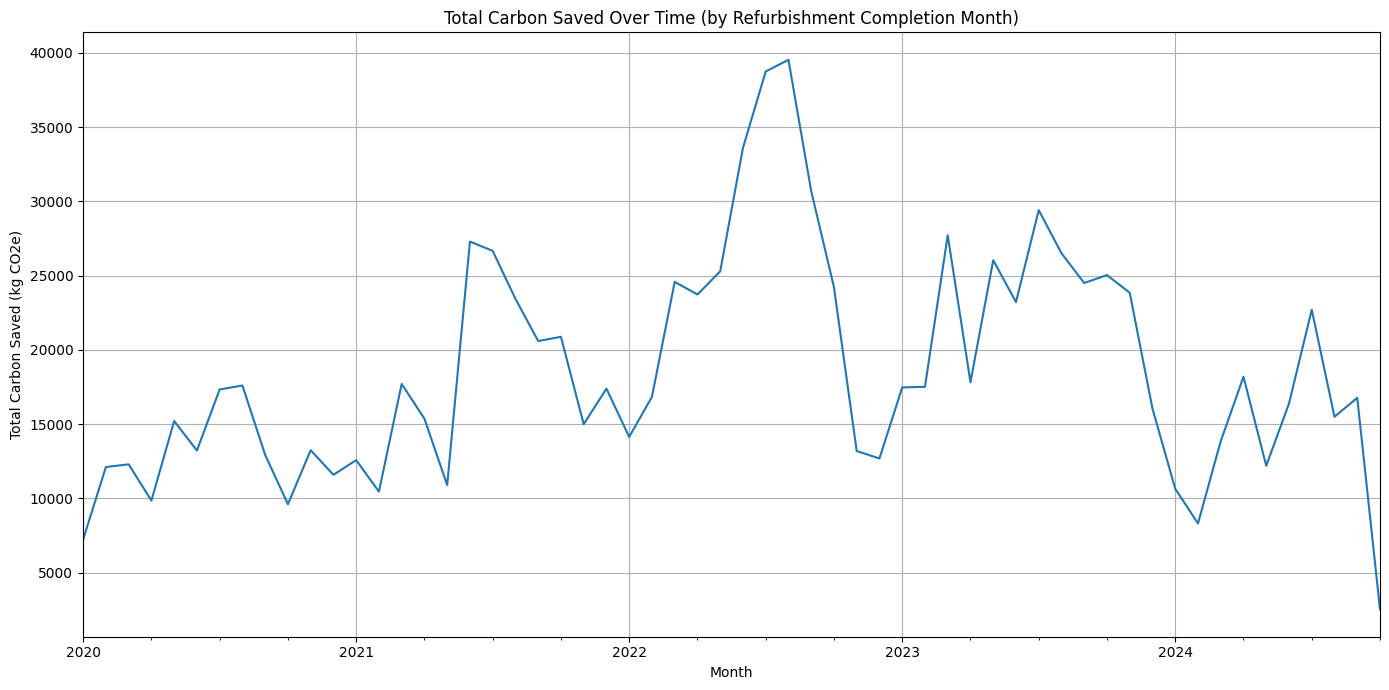

In [ ]:
# Merge environmental and refurb dataframes to get refurbishment completion date
environmental_with_dates = pd.merge(environmental, refurb[['asset_id', 'refurb_completion_date']], on='asset_id', how='left')

# Convert the 'refurb_completion_date' column to datetime objects
environmental_with_dates['refurb_completion_date'] = pd.to_datetime(environmental_with_dates['refurb_completion_date'])

# Group by month and calculate the sum of 'avoided_new_manufacturing_emissions'
carbon_saved_over_time = environmental_with_dates.set_index('refurb_completion_date').resample('ME')['avoided_new_manufacturing_emissions'].sum()

# Create a line plot
plt.figure(figsize=(14, 7))
carbon_saved_over_time.plot(kind='line')
plt.title('Total Carbon Saved Over Time (by Refurbishment Completion Month)')
plt.xlabel('Month')
plt.ylabel('Total Carbon Saved (kg CO2e)')
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
Now that the carbon savings over time plot is done, the next steps are to calculate and visualize the total carbon saved by device type as requested in the original instructions. This involves merging with the assets dataframe and then grouping and plotting.



/tmp/ipython-input-298352506.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=carbon_saved_by_device_type.index, y=carbon_saved_by_device_type.values, palette='viridis')


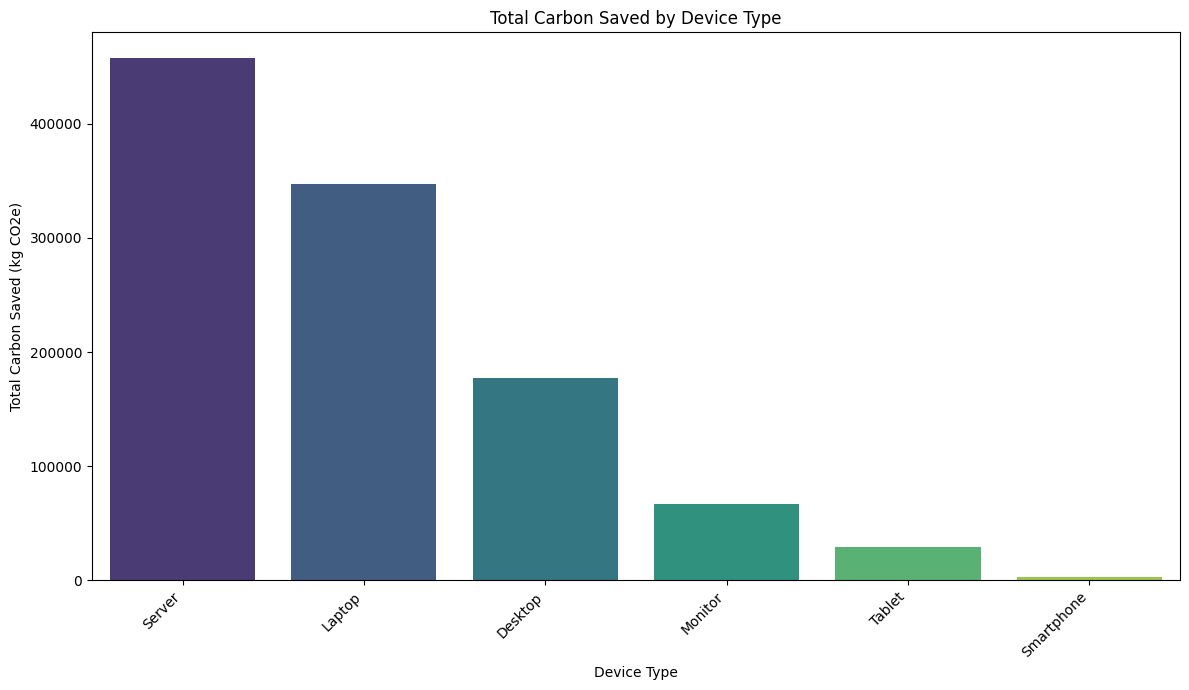

In [ ]:
# Merge the environmental DataFrame with the assets DataFrame to include device type information
environmental_with_assets = pd.merge(environmental, assets[['asset_id', 'device_type']], on='asset_id', how='left')

# Group by 'device_type' and calculate the sum of 'avoided_new_manufacturing_emissions'
carbon_saved_by_device_type = environmental_with_assets.groupby('device_type')['avoided_new_manufacturing_emissions'].sum().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x=carbon_saved_by_device_type.index, y=carbon_saved_by_device_type.values, palette='viridis')
plt.title('Total Carbon Saved by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Total Carbon Saved (kg CO2e)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Combine and analyze

### Subtask:
Analyze the relationships and trends observed across the different visualizations.


## Summary:

### Data Analysis Key Findings

*   All specified date and numerical columns across the `assets`, `refurb`, `sales`, and `environmental` dataframes were successfully converted to the correct data types (`datetime64[ns]`, `float64`, or `int64`).
*   The visualization of sales data showed trends in total sales revenue over time, by device type, and by sale channel.
*   Visualizations of refurbishment data provided insights into the refurbishment success rate by device type, the distribution of refurbishment duration, and the distribution of assessment duration by device type.
*   Visualizations of environmental impact successfully showed the total carbon saved over time (by refurbishment completion month) and the total carbon saved by different device types.

### Insights or Next Steps

*   Analyze the relationships between refurbishment metrics (like success rate and duration) and sales performance or environmental impact to identify potential areas for optimization.
*   Investigate device types with lower refurbishment success rates or higher carbon footprints to understand underlying causes and propose improvements.


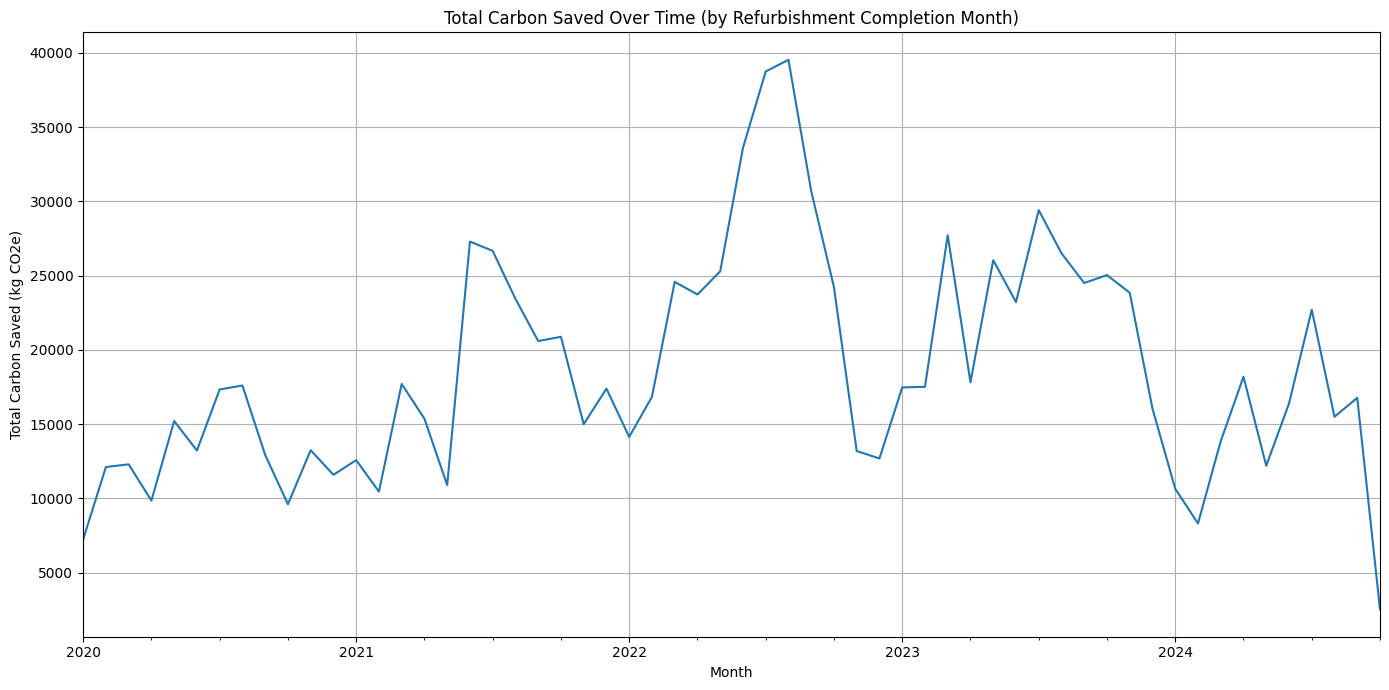

In [ ]:
# Merge environmental and refurb dataframes to get refurbishment completion date
environmental_with_dates = pd.merge(environmental, refurb[['asset_id', 'refurb_completion_date']], on='asset_id', how='left')

# Convert the 'refurb_completion_date' column to datetime objects
environmental_with_dates['refurb_completion_date'] = pd.to_datetime(environmental_with_dates['refurb_completion_date'])

# Group by month and calculate the sum of 'avoided_new_manufacturing_emissions'
carbon_saved_over_time = environmental_with_dates.set_index('refurb_completion_date').resample('ME')['avoided_new_manufacturing_emissions'].sum()

# Create a line plot
plt.figure(figsize=(14, 7))
carbon_saved_over_time.plot(kind='line')
plt.title('Total Carbon Saved Over Time (by Refurbishment Completion Month)')
plt.xlabel('Month')
plt.ylabel('Total Carbon Saved (kg CO2e)')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-298352506.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=carbon_saved_by_device_type.index, y=carbon_saved_by_device_type.values, palette='viridis')


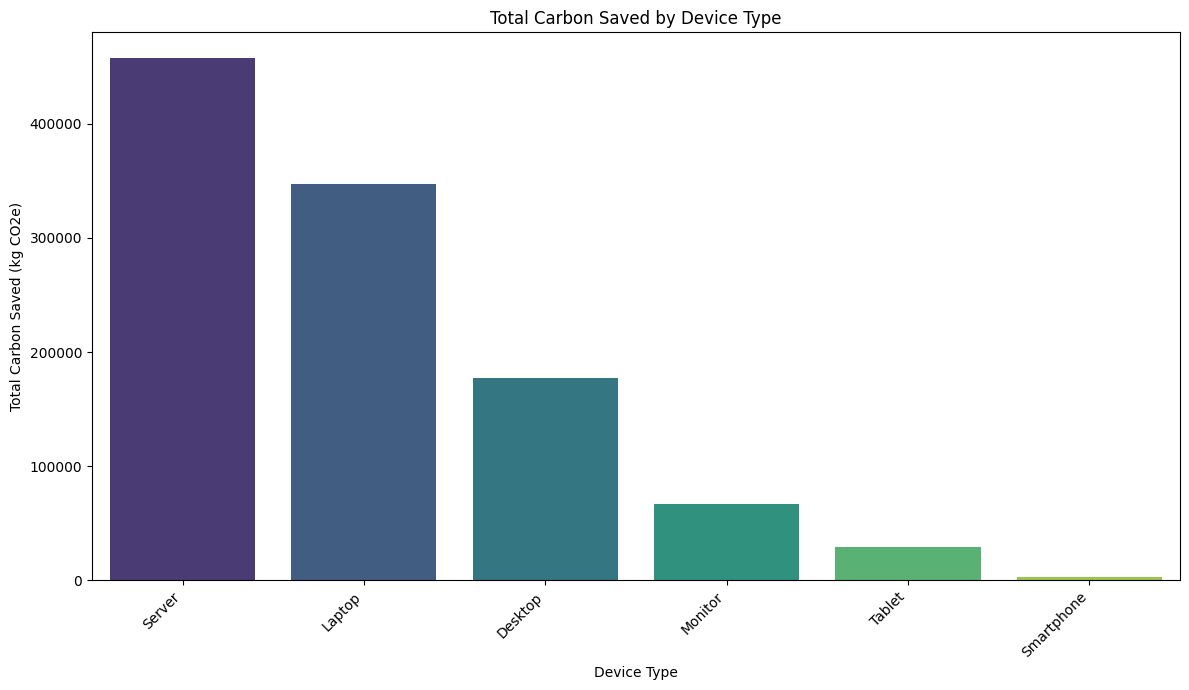

In [ ]:
# Merge the environmental DataFrame with the assets DataFrame to include device type information
environmental_with_assets = pd.merge(environmental, assets[['asset_id', 'device_type']], on='asset_id', how='left')

# Group by 'device_type' and calculate the sum of 'avoided_new_manufacturing_emissions'
carbon_saved_by_device_type = environmental_with_assets.groupby('device_type')['avoided_new_manufacturing_emissions'].sum().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x=carbon_saved_by_device_type.index, y=carbon_saved_by_device_type.values, palette='viridis')
plt.title('Total Carbon Saved by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Total Carbon Saved (kg CO2e)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()